In [1]:
import sys
from sys import getsizeof
from dis import dis
import timeit
from statistics import mean
from array import array
import pandas as pd
import numpy as np

from IPython.display import HTML, display

In [2]:
import os
import gc
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

# List

- lists are a mutable [Sequence Types](https://docs.python.org/3/library/stdtypes.html#typesseq)
- Tuples are immutable sequences

[PyListObject](https://github.com/python/cpython/blob/master/Include/listobject.h#L23) definition:
```C
typedef struct {
    PyObject_VAR_HEAD
    PyObject **ob_item;
    Py_ssize_t allocated;
} PyListObject;
```


[PyList_Append](https://github.com/python/cpython/blob/master/Objects/listobject.c#L348) definition:
    
    
[CPython’s lists are really variable-length arrays](https://docs.python.org/3/faq/design.html#id19). The implementation uses a contiguous array of references to other objects, and keeps a pointer to this array and the array’s length in a list head structure.

This makes indexing a list *a[i]* an operation whose cost is independent of the size of the list or the value of the index.

When items are appended or inserted, the array of references is resized. Some cleverness is applied to improve the performance of appending items repeatedly; when the array must be grown, some extra space is allocated so the next few times don’t require an actual resize.
   

https://github.com/python/cpython/blob/master/Objects/listobject.c

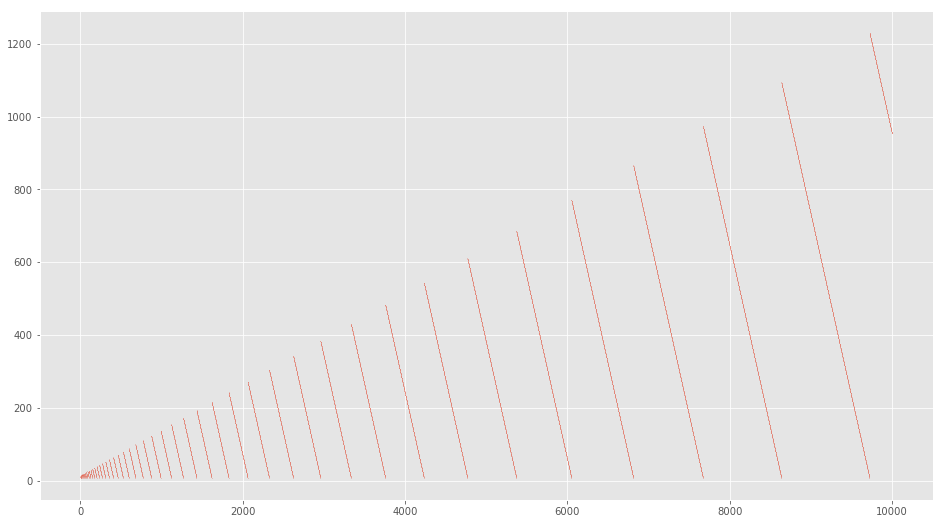

In [126]:
N = 10_000
l = []
y = np.empty(N)

elt_size = 8
for i in range(N):
    l.append(i)
    y[i] = (getsizeof(l) - 8 * i) / 8
    
# Plot that
fig = Figure(figsize=(16,9))
canvas = FigureCanvas(fig)

ax = fig.add_subplot(1, 1, 1)
ax.scatter(range(N), y, marker=".", s=0.1)
fig

https://jakevdp.github.io/PythonDataScienceHandbook/02.01-understanding-data-types.html

## memory

https://stackoverflow.com/questions/7247298

In [12]:
def f0():
    """Type constructor"""
    return list()

def f1():
    """square brackets"""
    return []

def f2():
    """square brackets with initial value"""
    return [1]

def f3():
    """square brackets and append"""
    lst = []
    lst.append(1)
    return lst

def f4():
    """Array, empty"""
    return array('i', [])

def f5():
    """Array"""
    return array('i', [1])

def f6():
    """Numpy"""
    return np.array([1])

def compute_timeit(func, n=7):
    """
    Return the average timeit computed time for a function func
    """
    t = timeit.Timer(func).repeat(repeat=7)
    return round(mean(t), 2)

f = [f0, f1, f2, f3, f4, f5, f6]

In [13]:
t = timeit.Timer(f1) #.repeat(repeat=7)

In [14]:
HTML("<center><table>"
     "<tr><th/><th>" + "</th><th>".join([_f.__doc__ for _f in f]) + "</th></tr>"
     "<tr><th>getsizeof</th><td>" + "</td><td>".join([str(getsizeof(_f())) for _f in f]) + "</td></tr>"
     "<tr><th>timeit [ns]</th><td>" + "</td><td>".join([str(compute_timeit(_f)) for _f in f]) + "</td></tr>"
     "</table></center>")

In [17]:
dis(f0)

  3           0 LOAD_GLOBAL              0 (list)
              2 CALL_FUNCTION            0
              4 RETURN_VALUE


In [18]:
dis(f1)

  7           0 BUILD_LIST               0
              2 RETURN_VALUE


In [19]:
dis(f2)

 11           0 LOAD_CONST               1 (1)
              2 BUILD_LIST               1
              4 RETURN_VALUE


In [20]:
dis(f3)

 15           0 BUILD_LIST               0
              2 STORE_FAST               0 (lst)

 16           4 LOAD_FAST                0 (lst)
              6 LOAD_METHOD              0 (append)
              8 LOAD_CONST               1 (1)
             10 CALL_METHOD              1
             12 POP_TOP

 17          14 LOAD_FAST                0 (lst)
             16 RETURN_VALUE


In [21]:
dis(f4)

 21           0 LOAD_GLOBAL              0 (array)
              2 LOAD_CONST               1 ('i')
              4 BUILD_LIST               0
              6 CALL_FUNCTION            2
              8 RETURN_VALUE


In [22]:
dis(f5)

 25           0 LOAD_GLOBAL              0 (array)
              2 LOAD_CONST               1 ('i')
              4 LOAD_CONST               2 (1)
              6 BUILD_LIST               1
              8 CALL_FUNCTION            2
             10 RETURN_VALUE


In [23]:
getsizeof(array('d', [1.0, 2.0, 3.14]))

88

In [24]:
getsizeof(np.array([1.0, 2.0, 3.14], dtype="d"))

120

## Memory allocation

In [57]:
from matplotlib.backends.backend_agg import FigureCanvas

<table>
  <tr>
    <td width='50%' style='font-size:150%;padding-right:5%;'>Everything in Python is an object. Some objects can hold other objects, such as lists, tuples, dicts, classes, etc. Because of dynamic Python's nature, such approach requires a lot of small memory allocations. To speed-up memory operations and reduce fragmentation Python uses a special manager on top of the general-purpose allocator, called <a href="https://github.com/python/cpython/blob/69f37bcb28d7cd78255828029f895958b5baf6ff/Objects/obmalloc.c#L733">PyMalloc</a>).</td>
    <td><img src='./img/memory_layers.svg'></td>
   </tr>
</table>

In [393]:
a = array('f', [12.4, 54.3, 23.9])

In [397]:
sorted(a)

[12.399999618530273, 23.899999618530273, 34.0, 34.0, 54.29999923706055]

In [395]:
insort(a, 34)

In [396]:
a

array('f', [12.399999618530273, 34.0, 34.0, 54.29999923706055, 23.899999618530273])

In [368]:
%%timeit
a1 = array('d', [1.0, 2.0, 3.14])
a1.append(4.5)

816 ns ± 2.53 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [370]:
a1 = array('d', [1.0, 2.0, 3.14])
a1.append(4.5)

In [377]:
a1[2:] * 3

array('d', [3.14, 4.5, 3.14, 4.5, 3.14, 4.5])

In [362]:
%%timeit 
np.array([1.0, 2.0, 3.14])

2.2 µs ± 21.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [177]:
# We will prepare artificial dataset that contains orders of the product.
# Each order will have random number of items ordered and random price within given range
range_products = [1,10000]  # number of products in the dataset
range_orders = [1,20]  # range of orders for product from which to select one random value
range_quantity = [1,100]  # range of quantity in order from which to select one random value
range_price = [0.1,50.00]  # range of product prices from which to select one random value

In [47]:
def generate_dummy_dataset(range_products,range_orders,products_quantity,products_price):
    generated_dataset = []
    for idx in range(*range_products):
        random_orders = random.randint(*range_orders) 
        for odx in range(random_orders):
            quantity = random.randint(*range_quantity)
            price = random.uniform(*range_price)
            generated_dataset.append([idx,odx,quantity,price])
    return generated_dataset

In [48]:
dataset_python = generate_dummy_dataset(range_products,range_orders,range_quantity,range_price)
print(f"Dataset size {dataset_python.__len__()} records\n")
print ('product_id,','product_order_num,','quantity,','price,')
dataset_python[0:3]

Dataset size 105081 records

product_id, product_order_num, quantity, price,


[[1, 0, 5, 21.974971011987638],
 [1, 1, 70, 38.1101844739709],
 [1, 2, 39, 21.10216058250481]]

In [106]:
from array import array

In [107]:
array('f', [])

array('f')

In [322]:
dis.dis('7 + 5')

  1           0 LOAD_CONST               2 (12)
              2 RETURN_VALUE


In [117]:
random.sample(range(0, 1000), 6)

[315, 149, 204, 611, 365, 959]

In [102]:
random.randint(*range_orders)

16

In [144]:
_s = 1000000
a = array('f', (random.randint(0, 1e6)/1000 for i in range(_s)))
b = [random.randint(0, 1e6)/1000 for i in range(_s)]
c = memoryview(a)

In [155]:
p = 10000

In [156]:
p

10000

In [172]:
%timeit a[p]

116 ns ± 0.908 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [173]:
%timeit b[p]

110 ns ± 0.873 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [174]:
%timeit c[p]

208 ns ± 3.51 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [175]:
c = np.random.randint(1e6, size=(_s,)) / 1000

In [176]:
%timeit c[p]

211 ns ± 3.42 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [92]:
a.append(0)

In [49]:
dataset_python.__len__()

105081

## 03a. Pure Python function (nested loops)

In [54]:
def gen_stats_python1(dataset_python):
    start = time.time()
    tag = 'Python ("nested loops")'
    product_stats = []
    unique_products = set([x[0] for x in dataset_python])
    for product_id in unique_products:
        product_items = [x for x in dataset_python if x[0] == product_id ]
        num_orders = len(product_items)
        total_quantity = 0
        total_price = 0
        for row in product_items:
            total_quantity += row[2]
            total_price += row[3]
        avg_price = float(total_price / num_orders)
        product_stats.append([product_id, num_orders, total_quantity, round(avg_price,2)])
    end = time.time()
    working_time = end - start
    return product_stats, working_time, tag

In [80]:
%%timeit -r7 -n2
dataset_python = generate_dummy_dataset(range_products,range_orders,range_quantity,range_price)
dataset_python.sort(key=lambda item: item[0])

431 ms ± 7.65 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [81]:
%%timeit -r7 -n2
dataset_python = generate_dummy_dataset(range_products,range_orders,range_quantity,range_price)
dataset_python = sorted(dataset_python, key=lambda item: item[0])

428 ms ± 5.38 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


## 03b. Pure Python function (rolling sums)

In [55]:
def gen_stats_python2(dataset_python):
    start = time.time()
    tag = 'Python ("rolling sums")'
    dataset_python = sorted(dataset_python, key=lambda item: item[0])
    product_stats = []
    prev_product_id = dataset_python[0][0]
    num_orders = 0
    sum_quantity = 0
    sum_prices = 0
    for row in dataset_python:
        if row[0]==prev_product_id:
            num_orders += 1
            sum_quantity += row[2]
            sum_prices += row[3]
        else:
            product_stats.append([prev_product_id, num_orders, sum_quantity, round(sum_prices/num_orders,2)])
            prev_product_id = row[0]
            num_orders = 1
            sum_quantity = row[2]
            sum_prices = row[3]
    product_stats.append([prev_product_id, num_orders, sum_quantity , round(sum_prices/num_orders,2)])                      
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

In [69]:
def gen_stats_python3(dataset_python):
    start = time.time()
    tag = 'Python ("rolling sums")'
    dataset_python.sort(key=lambda item: item[0])
    product_stats = []
    prev_product_id = dataset_python[0][0]
    num_orders = 0
    sum_quantity = 0
    sum_prices = 0
    for row in dataset_python:
        if row[0]==prev_product_id:
            num_orders += 1
            sum_quantity += row[2]
            sum_prices += row[3]
        else:
            product_stats.append([prev_product_id,int(num_orders),int(sum_quantity),round(sum_prices/num_orders,2)])
            prev_product_id = row[0]
            num_orders = 1
            sum_quantity = row[2]
            sum_prices = row[3]
    product_stats.append([prev_product_id,int(num_orders),int(sum_quantity),round(sum_prices/num_orders,2)])                      
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

In [70]:
dataset_python = generate_dummy_dataset(range_products,range_orders,range_quantity,range_price)

result = gen_stats_python3(dataset_python)
alg_time.append(result[1])
print (result[2],min(alg_time),'sec')
running_time.append ([result[2],min(alg_time)])

Python ("rolling sums") 0.08016157150268555 sec


## 04a. Pandas function (nested loops)

In [7]:
def gen_stats_pandas1(dataset_python):
    start = time.time()
    tag = 'Pandas ("nested loops")'
    dataset_pandas = pd.DataFrame(data=dataset_python,columns=['product_id','product_order_num','quantity','price'])
    product_stats = []
    for product_id in pd.unique(dataset_pandas['product_id']):
        product_items = dataset_pandas.loc[dataset_pandas['product_id'] == product_id]
        num_orders = product_items.shape[0]
        total_quantity = product_items['quantity'].sum()
        avg_price = float(product_items['price'].mean())
        product_stats.append([int(product_id),int(num_orders),int(total_quantity),round(avg_price,2)])
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 04b. Pandas function (group & aggregate)

In [8]:
def gen_stats_pandas2(dataset_python):
    start = time.time()
    tag = 'Pandas ("group/aggregate")'
    dataset_pandas = pd.DataFrame(data=dataset_python,columns=['product_id','product_order_num','quantity','price'])
    product_stats = []
    calc_stats = dataset_pandas.groupby('product_id')
    calc_stats = calc_stats.aggregate({'product_order_num': 'count','quantity': 'sum','price': 'mean'})
    calc_stats = calc_stats.reset_index().values.tolist()
    product_stats = [[int(item[0]),int(item[1]),int(item[2]),round(item[3],2)] for item in calc_stats]
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 05a. Numpy function (nested loops)

In [9]:
def gen_stats_numpy1(dataset_python):
    start = time.time()
    tag = 'Numpy ("nested loops")'
    dataset_numpy = np.array(dataset_python)
    product_stats = []
    for product_id in np.nditer(np.unique(dataset_numpy[:,0]),op_dtypes=['float64']):
        product_items = dataset_numpy[dataset_numpy[:,0] == product_id]
        num_orders = product_items.shape[0]
        total_quantity = product_items[:,2].sum()
        avg_price = float(product_items[:,3].mean())
        product_stats.append([int(product_id),int(num_orders),int(total_quantity),round(avg_price,2)])
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 05b. Numpy function (array split)

In [10]:
def gen_stats_numpy2(dataset_python):
    start = time.time()
    tag = 'Numpy ("array split")'
    dataset_numpy = np.array(dataset_python)
    unique_products,unique_indices = np.unique(dataset_numpy[:,0],return_index = True)
    split = np.split(dataset_numpy,unique_indices)[1:]
    product_stats = \
    [[int(item[0,0]),item.shape[0],int(np.sum(item[:,2])),float(np.round(np.sum(item[:,3])/item.shape[0],2))]\
     for item in split]
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 06. Prepare function dispatcher

In [71]:
dispatcher  = [gen_stats_python1,
               gen_stats_python2,
               gen_stats_python3,
               gen_stats_pandas1,
               gen_stats_pandas2,
               gen_stats_numpy1,
               gen_stats_numpy2]

## 07. Check if all functions generate the same result

In [57]:
gc.collect()
test_results = []
prev_result = None
for i in dispatcher:
    result = i(dataset_python)
    test_results.append(result)
    if prev_result == None:
        equal = None
    else:
        equal = (prev_result == result[0])
    prev_result = result[0]
    print (result[2],result[0][0:3],'equal : ',equal)

KeyboardInterrupt: 

In [58]:
# clear memory
del test_results 
gc.collect()

63

## 08. Compare running time

In [59]:
NUM_ITERATIONS = 1

In [72]:
running_time = []
for i in dispatcher:
    gc.collect()
    alg_time = []
    for j in range (NUM_ITERATIONS):
        result = i(dataset_python)
        alg_time.append(result[1])
    print (result[2],min(alg_time),'sec')
    running_time.append ([result[2],min(alg_time)])

Python ("nested loops") 106.14985823631287 sec
Python ("rolling sums") 0.09078502655029297 sec
Python ("rolling sums") 0.09452009201049805 sec
Pandas ("nested loops") 11.903373956680298 sec
Pandas ("group/aggregate") 0.1399831771850586 sec
Numpy ("nested loops") 11.160401344299316 sec
Numpy ("array split") 0.6070210933685303 sec


## 09. Present results

In [61]:
running_time = sorted(running_time, key=lambda item: item[1])
base_time_1x = running_time[-1][1]

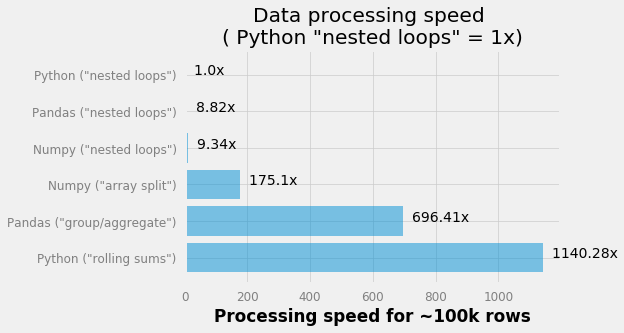

In [62]:
plt.style.use('fivethirtyeight')
objects = [x[0] for x in running_time]
y_rng = np.arange(len(objects))
performance = [base_time_1x/x[1] for x in running_time]
plt.barh(y_rng, performance, align='center', alpha=0.5)
plt.yticks(y_rng, objects)
plt.xlabel('Processing speed for ~100k rows')
plt.title('Data processing speed \n( Python "nested loops" = 1x)')
for a,b in zip(performance, y_rng):
    plt.text(a, b, "  "+str(round(a,2))+"x")
plt.show()